In [1]:
import numpy as np
import pandas as pd
from scipy import stats

from dataclasses import dataclass
from typing import Tuple


from scipy.optimize import minimize
from scipy.spatial.distance import cdist
import odor_stat_calculations as osc
from scipy.stats import kurtosis
import matplotlib.pyplot as plt 
import seaborn as sns
from figurefirst import mpl_functions
from scipy.ndimage import gaussian_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde
from itertools import groupby
from operator import itemgetter

%load_ext autoreload
%autoreload 2

LOAD Plume Model, and Empirical Whiff Stats, and test trajectory

In [ ]:
from cosmos_batch import COSMOSBatch

dirname1 = '../data/simulator/figure/Figure_hws/'
dirname = 'data/'
hmap_data = np.load(str(dirname) + "hmap.npz")
fdf = pd.read_hdf(str(dirname) + 'whiff.h5')
fdf_nowhiff = pd.read_hdf(str(dirname) + 'nowhiff.h5')
df_test = pd.read_hdf(str(dirname1) + 'hws_jan22.h5')  # Your test data - array of (x,y) points
# df_test = dfres[10000:]

# Extract required parameters
test_locations = df_test[['distance_along_streakline', 'nearest_from_streakline']].values
fitted_p_heatmap = hmap_data['fitted_heatmap']
xedges = hmap_data['xedges']
yedges = hmap_data['yedges']

# Create predictor directly and customize if needed
predictor = COSMOSBatch(
    fitted_p_heatmap=fitted_p_heatmap,
    xedges=xedges,
    yedges=yedges,
    fdf=fdf,
    fdf_nowhiff=fdf_nowhiff,
    test_locations=test_locations
)
results = predictor.predict()

# Use the results
df_test.loc[:, 'predicted_odor'] = results['concentrations']
df_test.loc[:, 'whiff_predicted'] = results['predictions']
# df_test.loc[:, 'logistic_transform'] = results['logistic_transform']
# df_test.loc[:, 'ar2_output'] = results['ar2_output']
# df_test.loc[:, 'target_concentration'] = results['target_concentration']

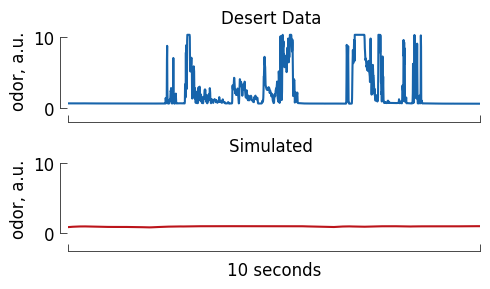

In [20]:
th=4.5
query1 = 'odor>'+ str(th)
new_test_df1 = df_test.query(query1)
new_test_df1.reset_index(inplace=True, drop=True)

query2 = 'predicted_odor>'+ str(th)
new_test_df2 = df_test.query(query2)
new_test_df2.reset_index(inplace=True, drop=True)

f,ax= plt.subplots(2,1,figsize=(5,3))
ax[0].plot(df_test.time, df_test.odor, label='original', c='#1764ab')
ax[1].plot(df_test.time, df_test.predicted_odor, label='predicted', c='#bc141a')
# ax[0].axhline(4.5, color = 'r', linestyle = '--')
# ax[1].axhline(4.5, color = 'r', linestyle = '--')
limit = (360,370)
ax[0].set_xlim(limit)
ax[1].set_xlim(limit)

# ax2.set_ylim(0,11)
ax[0].set_ylabel('odor, a.u.')
ax[1].set_ylabel('odor, a.u.')
ax[1].set_xlabel('10 seconds')
ax[0].set_title('Desert Data ')
ax[1].set_title('Simulated ')
ax[0].set_xticklabels([])
ax[1].set_xticklabels([])
for i in range(2):
    mpl_functions.adjust_spines(ax[i],['left','bottom'],
                            spine_locations={'left': 6}, 
                            smart_bounds=True,
                            xticks=[360,370],
                            yticks=[0, 10],
                            linewidth=0.5)
    mpl_functions.set_fontsize(ax[i],12)
f.tight_layout()

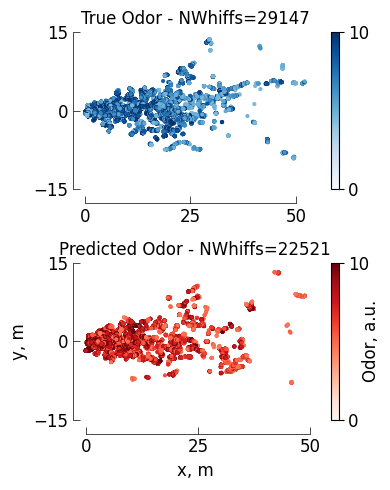

In [21]:
f, ax = plt.subplots(2, 1, figsize=(4, 5))

cax1 = ax[0].scatter(new_test_df1.distance_along_streakline, new_test_df1.nearest_from_streakline, c=new_test_df1.odor, s = 4, cmap='Blues', vmin=0, vmax=10)
cax2 = ax[1].scatter(new_test_df2.distance_along_streakline, new_test_df2.nearest_from_streakline, c=new_test_df2.predicted_odor, s = 4, cmap='Reds', vmin=0, vmax=10)
ax[0].set_title('True Odor - NWhiffs='+str(len(new_test_df1)))
ax[1].set_title('Predicted Odor - NWhiffs='+str(len(new_test_df2)))
# ax[0].set_title('Desert Data')
# ax[1].set_title('Simulated')
ax[1].set_xlabel('x, m')
ax[1].set_ylabel('y, m')
cb1=plt.colorbar(cax1)
cb2=plt.colorbar(cax2)
# cb1.set_label('Odor, a.u.',labelpad=-10)
cb2.set_label('Odor, a.u.',labelpad=-5)
cb1.set_ticks([0,10])
cb2.set_ticks([0,10])
for i in range(2):
    mpl_functions.adjust_spines(ax[i],['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[0,25,50],
                            yticks=[-15,0,15],
                            linewidth=0.5)
    mpl_functions.set_fontsize(ax[i],12)

f.tight_layout()

Plot Whiff Concentration vs distance histogram

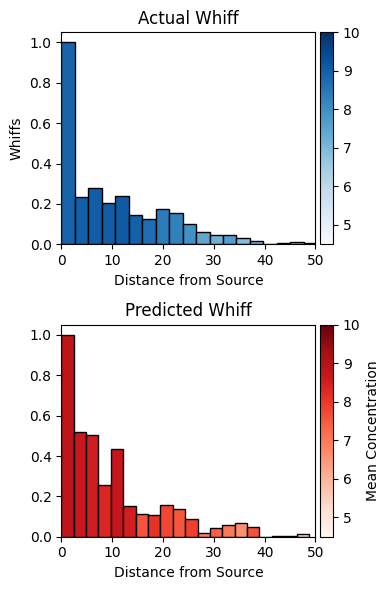

In [22]:
n_bins = 20

# Actual Whiff Data
df_actual = new_test_df1.copy()
bins = np.linspace(0, df_actual['distance_from_source'].max(), n_bins + 1)
df_actual['distance_bin'] = pd.cut(df_actual['distance_from_source'], bins=bins)

whiff_counts_actual = df_actual.groupby('distance_bin').size()
mean_concentrations_actual = df_actual.groupby('distance_bin')['odor'].mean()
bin_centers_actual = (bins[:-1] + bins[1:]) / 2

# Normalize actual whiff counts5
whiff_counts_actual_norm = whiff_counts_actual / whiff_counts_actual.max()

# Predicted Whiff Data
df_predicted = new_test_df2.copy()
bins_predicted = np.linspace(0, df_predicted['distance_from_source'].max(), n_bins + 1)
df_predicted['distance_bin'] = pd.cut(df_predicted['distance_from_source'], bins=bins_predicted)

whiff_counts_predicted = df_predicted.groupby('distance_bin').size()
mean_concentrations_predicted = df_predicted.groupby('distance_bin')['predicted_odor'].mean()
bin_centers_predicted = (bins_predicted[:-1] + bins_predicted[1:]) / 2

# Normalize predicted whiff counts
whiff_counts_predicted_norm = whiff_counts_predicted / whiff_counts_predicted.max()

# Create the subplots
f, ax = plt.subplots(2, 1, figsize=(4, 6))

# Plot for Actual Whiff Data
norm_actual = plt.Normalize(4.5, 10)
colors_actual = plt.cm.Blues(norm_actual(mean_concentrations_actual))
bars_actual = ax[0].bar(bin_centers_actual, whiff_counts_actual_norm, width=(bins[1] - bins[0]), edgecolor='black', color=colors_actual)

divider_actual = make_axes_locatable(ax[0])
cax_actual = divider_actual.append_axes("right", size="5%", pad=0.05)
sm_actual = plt.cm.ScalarMappable(cmap='Blues', norm=norm_actual)
sm_actual.set_array([])
cbar_actual = plt.colorbar(sm_actual, cax=cax_actual)

ax[0].set_xlabel('Distance from Source')
ax[0].set_ylabel('Whiffs')
ax[0].set_title('Actual Whiff')
# ax[0].set_ylim(0, 1)
ax[0].set_xlim(0, 50)

# Plot for Predicted Whiff Data
norm_predicted = plt.Normalize(4.5, 10)
colors_predicted = plt.cm.Reds(norm_predicted(mean_concentrations_predicted))
bars_predicted = ax[1].bar(bin_centers_predicted, whiff_counts_predicted_norm, width=(bins_predicted[1] - bins_predicted[0]), edgecolor='black', color=colors_predicted)

divider_predicted = make_axes_locatable(ax[1])
cax_predicted = divider_predicted.append_axes("right", size="5%", pad=0.05)
sm_predicted = plt.cm.ScalarMappable(cmap='Reds', norm=norm_predicted)
sm_predicted.set_array([])
cbar_predicted = plt.colorbar(sm_predicted, cax=cax_predicted)
cbar_predicted.set_label('Mean Concentration')

ax[1].set_xlabel('Distance from Source')
ax[1].set_title('Predicted Whiff')
# ax[1].set_ylim(0, 1)
ax[1].set_xlim(0, 50)

f.tight_layout()

Verify Whiff Statistics

In [23]:
new_test_df1=df_test.copy()
new_test_df2=df_test.copy()

In [24]:
def cal_stat(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff(df,idx,df2)
    osc.mean_avg(df,idx,df2)
    osc.encounter_frequency(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)

def cal_stat_predicted(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.predicted_mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff_predicted(df,idx,df2)
    osc.mean_avg_predicted(df,idx,df2)
    osc.encounter_frequency_predicted(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)
th = 4.5
np.seterr(divide='ignore')
index = osc.get_index(new_test_df1.odor,th)
index_predicted = osc.get_index(new_test_df2.predicted_odor,th)
fdf1 = pd.DataFrame()
fdf_predicted = pd.DataFrame()

cal_stat(new_test_df1,index,fdf1)
cal_stat_predicted(new_test_df2,index_predicted, fdf_predicted)

fdf1.keys()

/home/vbl/DataAnalysis/plume_sim/odor_stat_calculations.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.efreq.iloc[start] = 1


Index(['avg_dist_from_source', 'log_avg_dist_from_source',
       'mean_concentration', 'length_of_encounter', 'odor_intermittency',
       'log_whiff', 'log_blank', 'std_whiff', 'whiff_ma', 'wf', 'mean_time'],
      dtype='object')

Whiff Frequency

100%|██████████| 1000/1000 [00:00<00:00, 8358.55it/s]


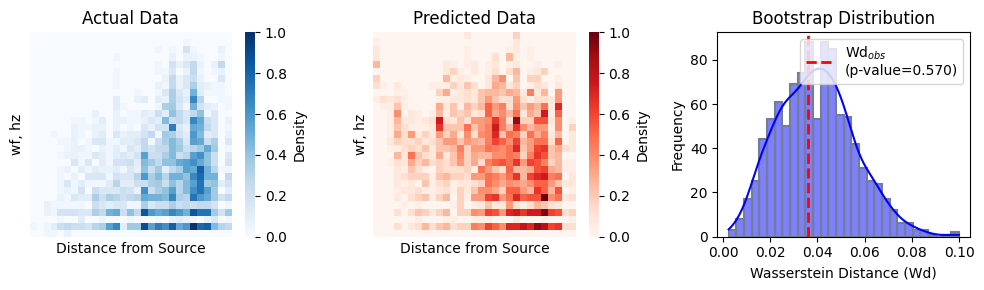

In [26]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.wf, fdf_predicted.log_avg_dist_from_source, fdf_predicted.wf, 'wf, hz', 0,1)

Whiff Duration

100%|██████████| 1000/1000 [00:00<00:00, 9621.11it/s]


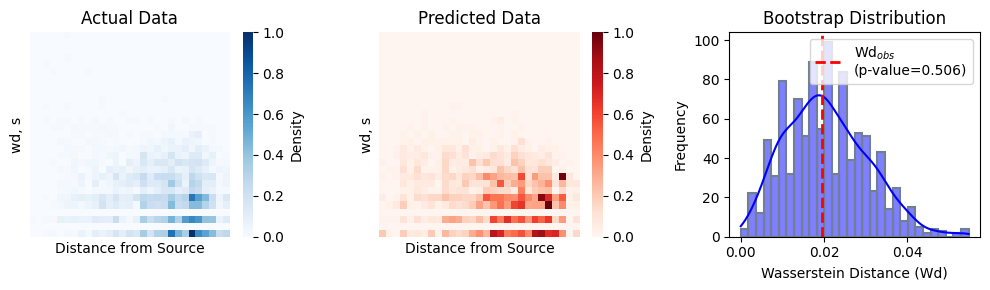

In [27]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.log_whiff, fdf_predicted.log_avg_dist_from_source, fdf_predicted.log_whiff, 'wd, s', 0,1)

Whiff Concentration

100%|██████████| 1000/1000 [00:00<00:00, 8132.77it/s]


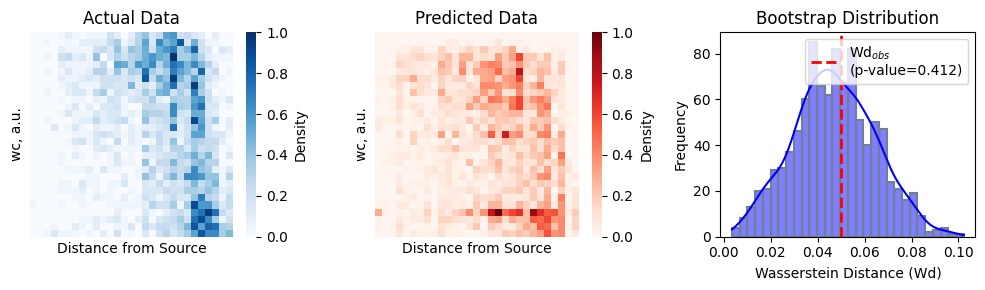

In [28]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.mean_concentration, fdf_predicted.log_avg_dist_from_source, fdf_predicted.mean_concentration, 'wc, a.u.', 0,1)

Whiff Standard Deviation

100%|██████████| 1000/1000 [00:00<00:00, 8039.78it/s]


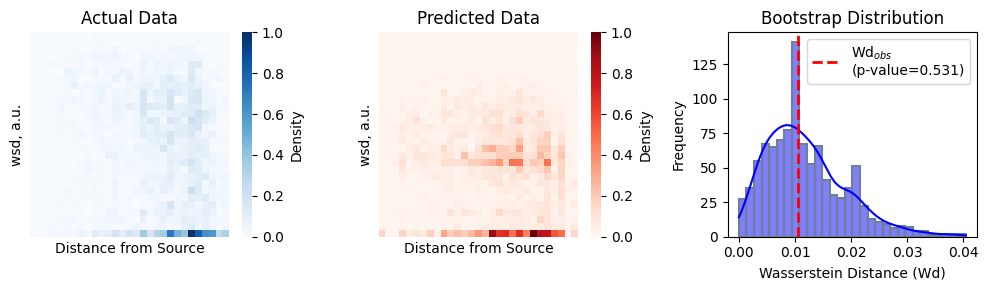

In [29]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.std_whiff, fdf_predicted.log_avg_dist_from_source, fdf_predicted.std_whiff, 'wsd, a.u.', 0,1)

Whiff Moving Average

100%|██████████| 1000/1000 [00:00<00:00, 8421.37it/s]


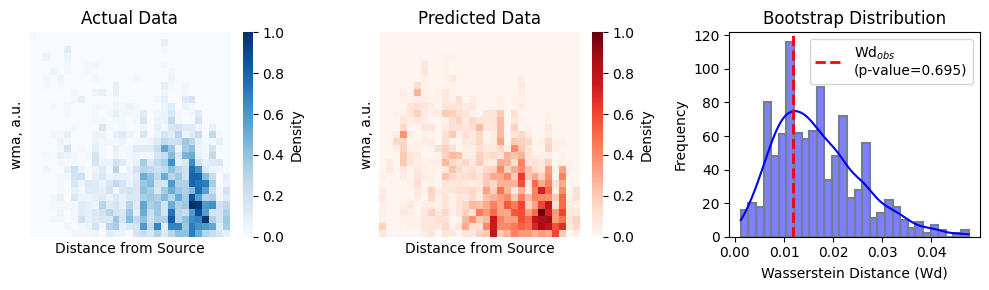

In [30]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.whiff_ma, fdf_predicted.log_avg_dist_from_source, fdf_predicted.whiff_ma, 'wma, a.u.', 0,1)